# Lab 3 : Feature selection for the fish dataset
Summary :
1. Load the dataset into a feature matrix (gray images, resizing and normalization)
2. Visualize some random samples
3. Try the PCA technique of reduction of dimensionality
4. Try a classifier with the inital features and the PCA components to compare their accuracy

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

## 1. Load the dataset into a feature matrix

In [2]:
DATASET_PATH = '../data/Fish_Dataset/Fish_Dataset/'

folders = os.listdir(DATASET_PATH)

# Get the labels name
labels = []
for f in folders:
    if not('.m' in f) and not('.txt' in f):
        labels.append(f)
labels = np.array(labels)

# Get the images for each label
img_shape = (128, 128) #resizing images to this shape ( after converting color image to gray image)
n_sample_per_class = 600 #Keep only this number of samples per class (expensive complexity issue)
nb_img = n_sample_per_class*len(labels) #1000 images per class

X = np.zeros((nb_img, img_shape[0]*img_shape[1])) # feature matrix
Y = np.zeros(nb_img) #labels vector
for i in range(len(labels)):
    folder = os.path.join(DATASET_PATH, labels[i], labels[i])
    images = os.listdir(folder)
    np.random.shuffle(images)
    for j in range(n_sample_per_class):
        img_path = os.path.join(folder, images[j])
        img = cv2.imread(img_path, 0) #Load the gray image
        #Resizing
        img = cv2.resize(src=img, dsize=img_shape)
        #Normalization
        img = img/255
        #Add the image in the feature matrix and its labels to the label vector
        X[i*n_sample_per_class+j, :] = img.flatten()
        Y[i*n_sample_per_class+j] = np.argwhere(labels==labels[i])[0]

In [3]:
print("Feature matrix : \n", X)
print("Label vector : \n", Y)

Feature matrix : 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Label vector : 
 [0. 0. 0. ... 8. 8. 8.]


## 2.Visualize some random samples after converting to gray, normalizationa nd resizing

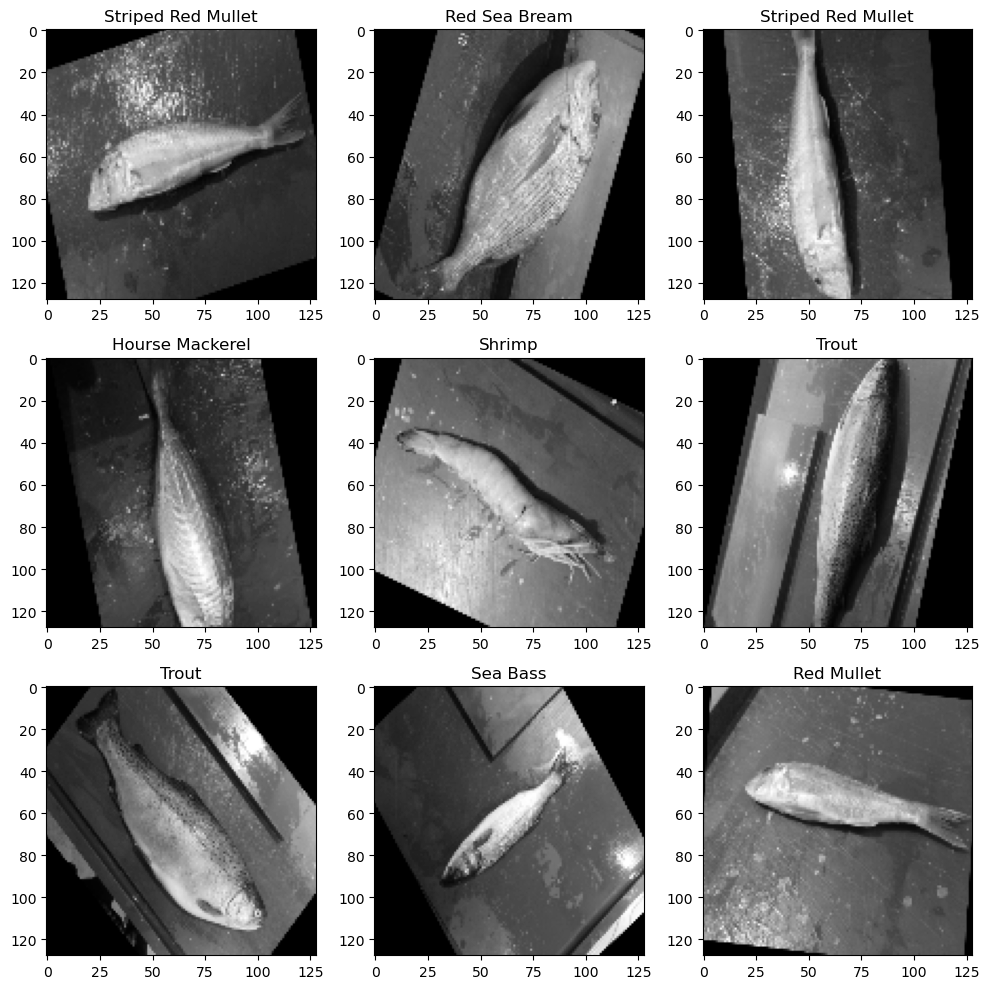

In [4]:
n_view = 9

plt.figure(figsize=(10,10))
for i in range(n_view):
    idx = np.random.randint(0, X.shape[0])
    img_view = X[idx, :]
    label_view = Y[idx]
    plt.subplot(3, 3, i+1)
    plt.imshow(img_view.reshape(img_shape), cmap='gray')
    plt.title(labels[int(label_view)])
plt.tight_layout()
plt.show()


## 3.Try the PCA technique of reduction of dimensionality
### 3.1 Create 3 datasets with 2, 5 and 10 top feature per class


In [5]:
from sklearn.decomposition import PCA

In [6]:
def pca_per_class(X, n_components):
    """
    Create another dataset by selecting the n_components the most correlated for each class by using PCA for each class
    :param X: the inital matrix feature
    :param n_components: number of components to keep for each class
    :return: X_pca : the new matrix feature
    """
    pca_classes = [] #list with the PCA instance for each class
    for i in range(len(labels)):
        idx_samples = np.argwhere(Y == i)[:, 0]
        X_class_i = X[idx_samples, :] # keep only the samples for the class i
        #Instanciate the PCA
        pca_i = PCA(n_components=n_components)
        #Train the PCA
        pca_i.fit_transform(X_class_i)
        #Add to the list
        pca_classes.append(pca_i)
    #Transform the inital matrix feature with the PCA of the first class
    X_pca = pca_classes[0].transform(X)
    #Concatenate the other transform matrix to create the new matrix feature
    for i in range(1, len(labels)):
        X_pca_i = pca_classes[i].transform(X)
        X_pca = np.concatenate((X_pca, X_pca_i), axis=1)
    return X_pca


In [7]:
X_pca_2 = pca_per_class(X, 2)
X_pca_5 = pca_per_class(X, 5)
X_pca_10 = pca_per_class(X, 10)

In [ ]:
print('Feature matrix dataset with 2 most correlate feature per class : \n', X_pca_2)

Feature matrix dataset with 2 most correlate feature per class : 
 [[-13.47547156  -4.23992982   8.23831557 ...  14.92238967  -4.76885153
   -4.4757593 ]
 [  8.61552096  -6.35690652  -4.30423588 ...   3.89495126   3.56754033
  -10.0928919 ]
 [ 11.5952371    0.42208865  -7.14371835 ...  -2.03627416   4.4924871
   -4.11571383]
 ...
 [  7.28204033  -1.43661165  -1.38719765 ...  -1.54913249   7.93594352
   -4.87403012]
 [  4.26084452  -6.76053461   6.93692096 ...   2.55315321  11.7687307
   -3.36102928]
 [ -2.73285413   0.55407872 -11.76653846 ...  -1.98507687  -8.63526197
    1.55111135]]


### 3.2 Find a relevant number of components for a PCA on all the inital dataset

In [ ]:
pca = PCA()
transform_matrix = pca.fit_transform(X)

Text(0.5, 0, 'Number of components')

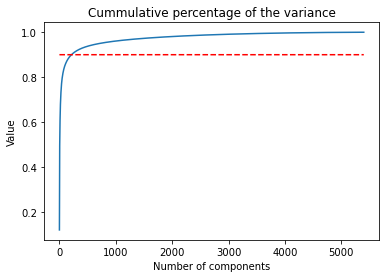

In [ ]:
#Cummulative percentage of variance explained by each of the PCA components
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure()
plt.plot(explained_variance)
plt.plot(0.9*np.ones(len(explained_variance)), color='r', linestyle='dashed')
plt.title('Cummulative percentage of the variance')
plt.ylabel('Value')
plt.xlabel('Number of components')


Regarding the cummulative percentage of the variance, we can choose a number of PCA components relatively low which can lead to a high cummulative variance. For example, we can take the number of components which corresponds to at least a cummulative variance of 0.9.

In [ ]:
nb_component = np.argwhere(explained_variance>=0.9)[0, 0]
print("Number of components : {}".format(nb_component))
print("Corresponding cummulative varaince : {}".format(explained_variance[nb_component]))

Number of components : 214
Corresponding cummulative varaince : 0.9000433205230655


### 3.2 Apply the PCA with the selected number of components

In [ ]:
pca = PCA(nb_component)
transform = pca.fit_transform(X)

### 3.3 Visualize the first PCA axis (48 plots here)

In [ ]:
fig, axes = plt.subplots(6,8, figsize=(16, 12),
                         subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    nn = ax.imshow( np.abs(pca.components_[i].reshape(128, 128)) , cmap='jet')
    ax.set_title(str(i))
    #fig.colorbar(nn,ax=ax)
plt.tight_layout()

## 4. Try a classifier with the inital features and the PCA components to compare their accuracy
### 4.1 SVM classifier on the initial feature matrix

In [ ]:
import datetime

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import svm

In [ ]:
def apply_SVM_model(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

    t0 = datetime.datetime.now()
    model = svm.SVC(random_state=0)
    model.fit(X_train, y_train)
    tf = datetime.datetime.now() - t0
    print('Training time : {}'.format(tf))

    y_pred = model.predict(X_test)
    print('Evaluation on the test data set :')
    class_report = classification_report(y_test, y_pred)
    print(class_report)
    confMat = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
    confMat_display = ConfusionMatrixDisplay(confMat, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
    confMat_display.plot()
    return  model, class_report

### 4.2 SVM classifier after the PCA

Training time : 0:00:04.374003
Evaluation on the test data set :
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88       134
         1.0       0.88      0.93      0.91       114
         2.0       0.88      0.90      0.89       114
         3.0       0.91      0.96      0.93       120
         4.0       0.90      0.95      0.92       114
         5.0       0.84      0.79      0.81       119
         6.0       0.92      0.95      0.94       109
         7.0       0.93      0.80      0.86       128
         8.0       0.89      0.89      0.89       128

    accuracy                           0.89      1080
   macro avg       0.89      0.89      0.89      1080
weighted avg       0.89      0.89      0.89      1080



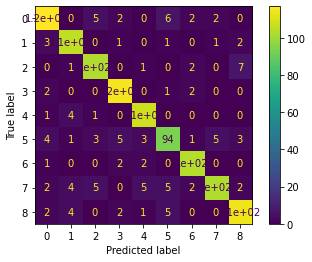

Training time : 0:00:04.849040
Evaluation on the test data set :
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88       134
         1.0       0.88      0.93      0.91       114
         2.0       0.88      0.90      0.89       114
         3.0       0.91      0.96      0.93       120
         4.0       0.90      0.95      0.92       114
         5.0       0.84      0.79      0.81       119
         6.0       0.92      0.95      0.94       109
         7.0       0.93      0.80      0.86       128
         8.0       0.89      0.89      0.89       128

    accuracy                           0.89      1080
   macro avg       0.89      0.89      0.89      1080
weighted avg       0.89      0.89      0.89      1080



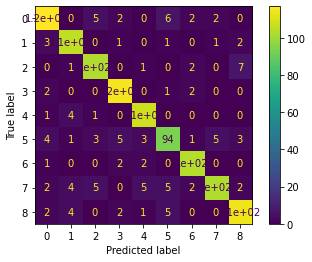

In [ ]:
svm_pca_216, class_report = apply_SVM_model(pca.transform(X), Y) #216 features

Training time : 0:00:00.778998
Evaluation on the test data set :
              precision    recall  f1-score   support

         0.0       0.48      0.37      0.41       134
         1.0       0.45      0.55      0.50       114
         2.0       0.40      0.57      0.47       114
         3.0       0.64      0.72      0.68       120
         4.0       0.47      0.49      0.48       114
         5.0       0.38      0.35      0.37       119
         6.0       0.61      0.83      0.70       109
         7.0       0.58      0.35      0.44       128
         8.0       0.61      0.41      0.49       128

    accuracy                           0.51      1080
   macro avg       0.51      0.52      0.50      1080
weighted avg       0.52      0.51      0.50      1080



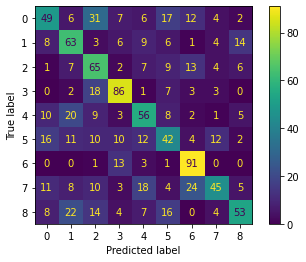

Training time : 0:00:00.815044
Evaluation on the test data set :
              precision    recall  f1-score   support

         0.0       0.48      0.37      0.41       134
         1.0       0.45      0.55      0.50       114
         2.0       0.40      0.57      0.47       114
         3.0       0.64      0.72      0.68       120
         4.0       0.47      0.49      0.48       114
         5.0       0.38      0.35      0.37       119
         6.0       0.61      0.83      0.70       109
         7.0       0.58      0.35      0.44       128
         8.0       0.61      0.41      0.49       128

    accuracy                           0.51      1080
   macro avg       0.51      0.52      0.50      1080
weighted avg       0.52      0.51      0.50      1080



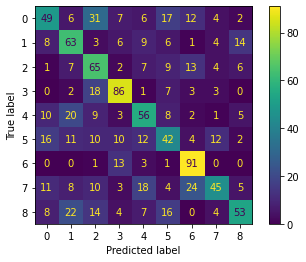

In [ ]:
svm_pca2, class_report_pca2 = apply_SVM_model(X_pca_2, Y) #2 features per class = 18 features

Training time : 0:00:01.216998
Evaluation on the test data set :
              precision    recall  f1-score   support

         0.0       0.53      0.37      0.44       134
         1.0       0.56      0.60      0.58       114
         2.0       0.41      0.60      0.49       114
         3.0       0.67      0.72      0.69       120
         4.0       0.56      0.59      0.57       114
         5.0       0.42      0.44      0.43       119
         6.0       0.59      0.82      0.69       109
         7.0       0.58      0.38      0.46       128
         8.0       0.72      0.53      0.61       128

    accuracy                           0.55      1080
   macro avg       0.56      0.56      0.55      1080
weighted avg       0.56      0.55      0.55      1080



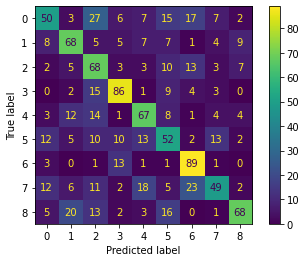

Training time : 0:00:01.242995
Evaluation on the test data set :
              precision    recall  f1-score   support

         0.0       0.53      0.37      0.44       134
         1.0       0.56      0.60      0.58       114
         2.0       0.41      0.60      0.49       114
         3.0       0.67      0.72      0.69       120
         4.0       0.56      0.59      0.57       114
         5.0       0.42      0.44      0.43       119
         6.0       0.59      0.82      0.69       109
         7.0       0.58      0.38      0.46       128
         8.0       0.72      0.53      0.61       128

    accuracy                           0.55      1080
   macro avg       0.56      0.56      0.55      1080
weighted avg       0.56      0.55      0.55      1080



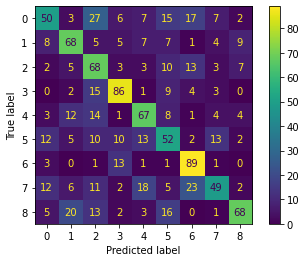

In [ ]:
svm_pca5, class_report_pca5 = apply_SVM_model(X_pca_5, Y) #5 features per class = 45 features

Training time : 0:00:01.965977
Evaluation on the test data set :
              precision    recall  f1-score   support

         0.0       0.70      0.51      0.59       134
         1.0       0.64      0.69      0.67       114
         2.0       0.59      0.70      0.64       114
         3.0       0.78      0.82      0.80       120
         4.0       0.65      0.76      0.70       114
         5.0       0.54      0.51      0.52       119
         6.0       0.63      0.85      0.72       109
         7.0       0.64      0.49      0.56       128
         8.0       0.83      0.67      0.74       128

    accuracy                           0.66      1080
   macro avg       0.67      0.67      0.66      1080
weighted avg       0.67      0.66      0.66      1080



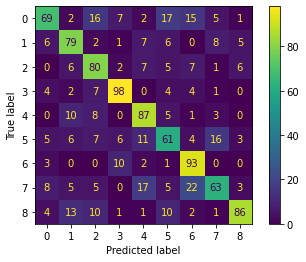

Training time : 0:00:01.975056
Evaluation on the test data set :
              precision    recall  f1-score   support

         0.0       0.70      0.51      0.59       134
         1.0       0.64      0.69      0.67       114
         2.0       0.59      0.70      0.64       114
         3.0       0.78      0.82      0.80       120
         4.0       0.65      0.76      0.70       114
         5.0       0.54      0.51      0.52       119
         6.0       0.63      0.85      0.72       109
         7.0       0.64      0.49      0.56       128
         8.0       0.83      0.67      0.74       128

    accuracy                           0.66      1080
   macro avg       0.67      0.67      0.66      1080
weighted avg       0.67      0.66      0.66      1080



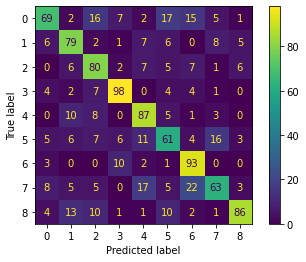

In [ ]:
svm_pca10, class_report_pca10 = apply_SVM_model(X_pca_10, Y) #10 features per class = 90 features

The f1_score measure which is the harmonic mean of recall and precision for each class seems to be the most relevant metric in this case of multi-class classification. Indeed, the overall accuracy can be high even if some classes can be not very good classified.
However, in order to evaluate more precisely the metrics of each model and so to be able to compare them, it seems essential to use cross-validation.

## 5. Evaluate the different models trained with different dataset
### 5.1 Use 10-fold cross-validation to compute the metrics : accuracy, precision, recall, f1-score


In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate, cross_val_predict

In [ ]:
def plot_metrics_evolution_cv(score_cv, metric_keys, colors, title, ax=None):
    if ax is None:
        plt.figure()
    for i in range(len(metric_keys)):
        label = metric_keys[i].split('_')[-1]
        if ax is None :
            plt.plot(score_cv[metric_keys[i]], color=colors[i], label=label, linewidth=1)
            plt.plot(np.arange(0, len(score_cv[metric_keys[i]])), np.mean(score_cv[metric_keys[i]])*np.ones(len(score_cv[metric_keys[i]])), linestyle='dashed', color=colors[i])
            print('Mean of the {} : {}'.format(label, np.round(np.mean(score_cv[metric_keys[i]]), decimals=3)))
        else:
            ax.plot(score_cv[metric_keys[i]], color=colors[i], label=label, linewidth=1)
            ax.plot(np.arange(0, len(score_cv[metric_keys[i]])), np.mean(score_cv[metric_keys[i]])*np.ones(len(score_cv[metric_keys[i]])), linestyle='dashed', color=colors[i])
    plt.xlabel('Fold')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()


Mean of the Accuracy : 0.909
Mean of the Precision : 0.911
Mean of the Recall : 0.909
Mean of the score : 0.909


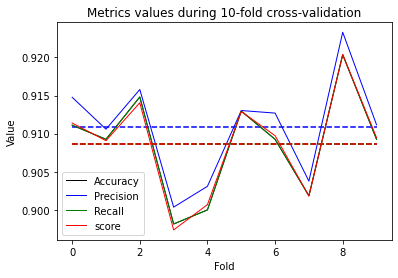

In [ ]:
# Define a dictionary with the metrics you want to use to evaluate the model
scoring = {"Accuracy": make_scorer(accuracy_score), "Precision": make_scorer(precision_score, average='macro'), 'Recall': make_scorer(recall_score, average='macro'), 'F1_score': make_scorer(f1_score, average='macro')}

#Compute the metrics in each fold of the cross-validation
score_cv = cross_validate(svm.SVC(random_state=0, decision_function_shape='ovr'), pca.transform(X), Y, scoring=scoring, cv=10) #scores
y_pred_cv = cross_val_predict(svm.SVC(random_state=0, decision_function_shape='ovr'), pca.transform(X), Y, cv=10) #predicitions during the cross-validation for each sample


#Plot the evolution of the metrics during cross-validation
colors = ['k', 'b', 'g', 'r']
metric_keys = ['test_Accuracy', 'test_Precision', 'test_Recall', 'test_F1_score']
plot_metrics_evolution_cv(score_cv, metric_keys, colors, title='Metrics values during 10-fold cross-validation')

In [ ]:
print(classification_report(Y, y_pred_cv))

              precision    recall  f1-score   support

         0.0       0.87      0.92      0.90       600
         1.0       0.89      0.88      0.89       600
         2.0       0.90      0.95      0.93       600
         3.0       0.92      0.94      0.93       600
         4.0       0.94      0.94      0.94       600
         5.0       0.84      0.86      0.85       600
         6.0       0.95      0.92      0.94       600
         7.0       0.94      0.84      0.89       600
         8.0       0.93      0.92      0.93       600

    accuracy                           0.91      5400
   macro avg       0.91      0.91      0.91      5400
weighted avg       0.91      0.91      0.91      5400



### 5.2 Compare the 4 datasets (2-5 and 10 top features per classes using PCA and 216 top features using PCA)

In [ ]:
score_cv_pca2 = cross_validate(svm.SVC(random_state=0, decision_function_shape='ovr'), X_pca_2, Y, scoring=scoring, cv=10) #scores
score_cv_pca5 = cross_validate(svm.SVC(random_state=0, decision_function_shape='ovr'), X_pca_5, Y, scoring=scoring, cv=10) #scores
score_cv_pca10 = cross_validate(svm.SVC(random_state=0, decision_function_shape='ovr'), X_pca_10, Y, scoring=scoring, cv=10) #scores

Mean of the Accuracy : 0.529
Mean of the Precision : 0.533
Mean of the Recall : 0.529
Mean of the score : 0.523


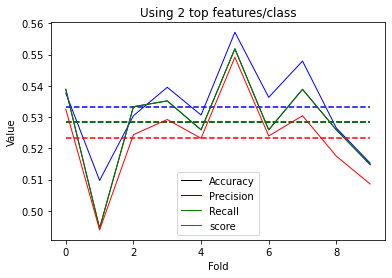

Mean of the Accuracy : 0.57
Mean of the Precision : 0.574
Mean of the Recall : 0.57
Mean of the score : 0.566


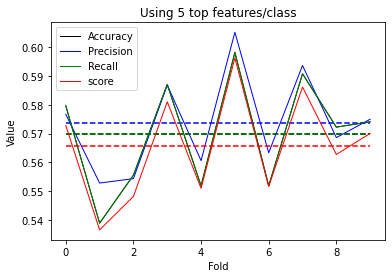

Mean of the Accuracy : 0.691
Mean of the Precision : 0.697
Mean of the Recall : 0.691
Mean of the score : 0.69


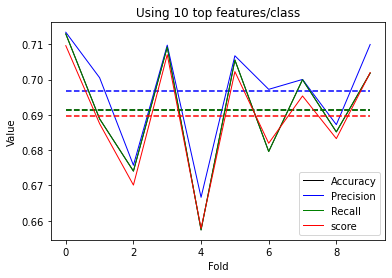

In [ ]:
plot_metrics_evolution_cv(score_cv_pca2, metric_keys, colors, title='Using 2 top features/class')

plot_metrics_evolution_cv(score_cv_pca5, metric_keys, colors, title='Using 5 top features/class')

plot_metrics_evolution_cv(score_cv_pca10, metric_keys, colors, title='Using 10 top features/class')


#### Plot the boxplots for each metric and each dataset :

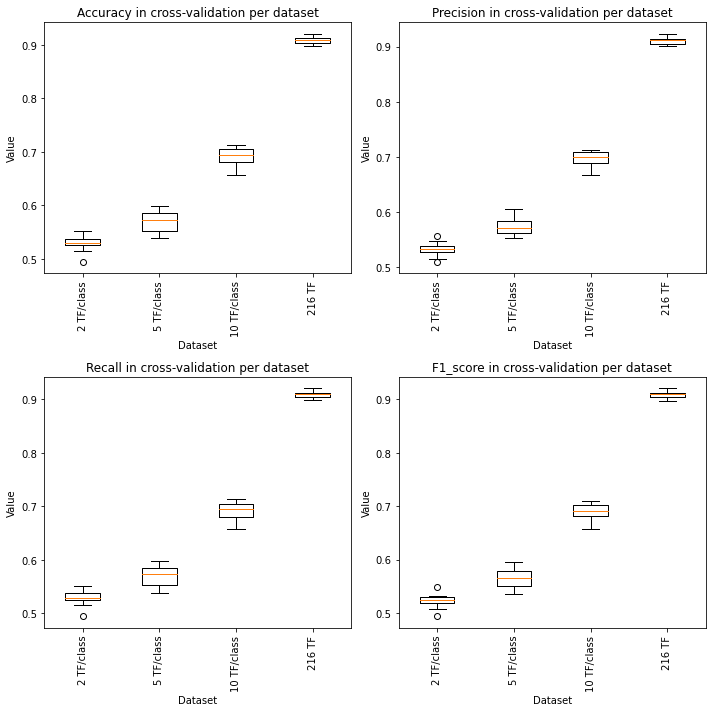

In [ ]:
legend_labels = ['2 TF/class', '5 TF/class', '10 TF/class', '216 TF'] #TF for top features

n_r, n_c = 2, 2

plt.figure(figsize=(10, 10))
for i in range(len(metric_keys)):
    plt.subplot(n_r, n_c, i+1)
    metric_key = metric_keys[i]
    plt.title('{} in cross-validation per dataset'.format(metric_key.split('test_')[-1]))
    plt.boxplot([score_cv_pca2[metric_key], score_cv_pca5[metric_key], score_cv_pca10[metric_key], score_cv[metric_key]])
    plt.xticks(np.arange(1, 5), legend_labels, rotation=90)
    plt.xlabel('Dataset')
    plt.ylabel('Value')
plt.tight_layout()


#### Plot the operating curves for each dataset :
TODO